In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, x):
        activation = torch.relu(self.encoder_hidden_layer(x))
        code = torch.relu(self.encoder_output_layer(activation))
        activation = torch.relu(self.decoder_hidden_layer(code))
        reconstruction = torch.relu(self.decoder_output_layer(activation))
        return reconstruction

In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_shape=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [5]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    for batch_features, _ in loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)

        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    for batch_features, _ in loader:
        
        batch_features = batch_features.to(device)
        
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(test_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28), nrows=2))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28), nrows=2))

# Simple Autoencoder

epoch : 1/10, Train loss = 0.030983
epoch : 1/10, Test loss = 0.018012


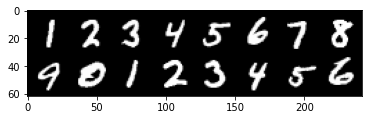

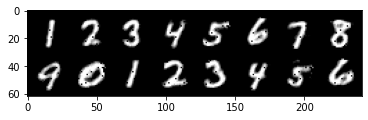

epoch : 2/10, Train loss = 0.016311
epoch : 2/10, Test loss = 0.014380


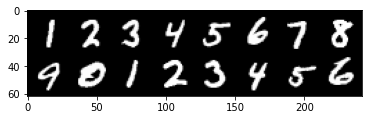

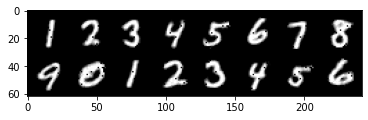

epoch : 3/10, Train loss = 0.013885
epoch : 3/10, Test loss = 0.013019


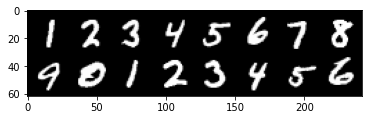

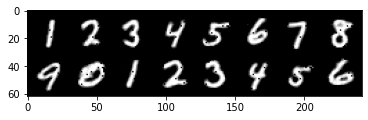

epoch : 4/10, Train loss = 0.012886
epoch : 4/10, Test loss = 0.012323


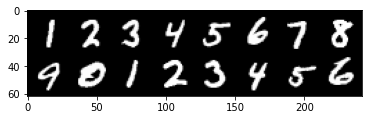

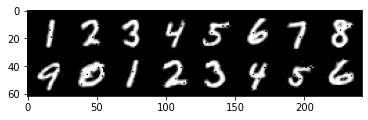

epoch : 5/10, Train loss = 0.012259
epoch : 5/10, Test loss = 0.011771


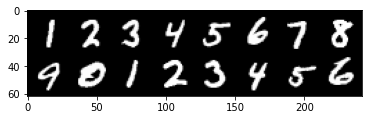

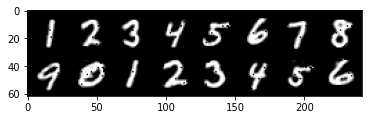

epoch : 6/10, Train loss = 0.011789
epoch : 6/10, Test loss = 0.011355


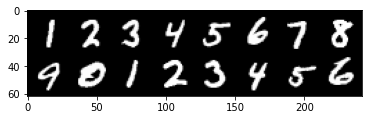

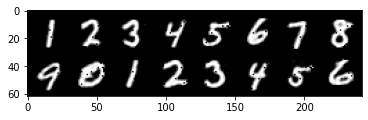

epoch : 7/10, Train loss = 0.011443
epoch : 7/10, Test loss = 0.011048


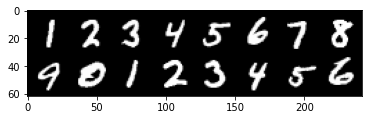

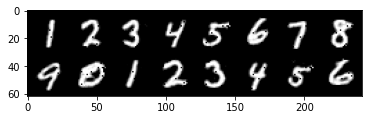

epoch : 8/10, Train loss = 0.011144
epoch : 8/10, Test loss = 0.010951


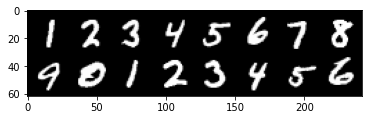

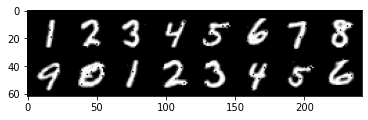

epoch : 9/10, Train loss = 0.010922
epoch : 9/10, Test loss = 0.010618


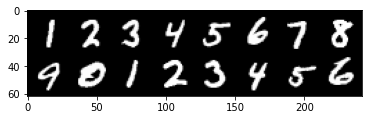

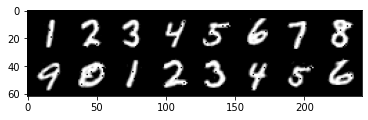

epoch : 10/10, Train loss = 0.010751
epoch : 10/10, Test loss = 0.010487


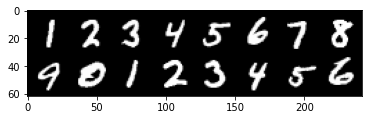

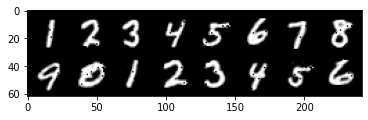

In [8]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

# Convolutional Autoencoder


## Exercise 1

Build the decoder for the convolutional autoencoder model and train it using the same functions and hyper-parameters as defined above.



In [9]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential( 
            
            nn.ConvTranspose2d(8,16,3, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8, 5, stride = 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8,1,2, stride = 2, padding = 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.095513
epoch : 1/10, Test loss = 0.058445


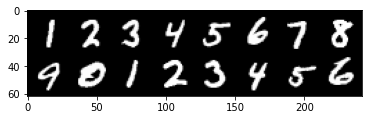

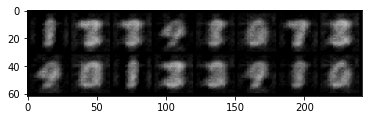

epoch : 2/10, Train loss = 0.051840
epoch : 2/10, Test loss = 0.045999


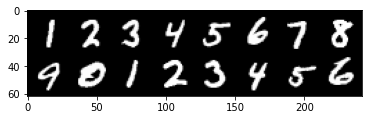

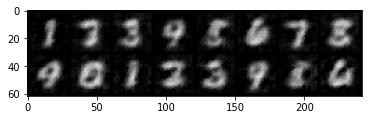

epoch : 3/10, Train loss = 0.043138
epoch : 3/10, Test loss = 0.040401


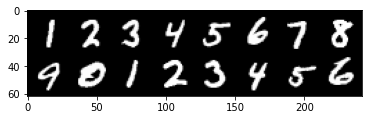

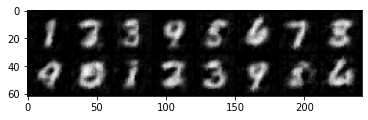

epoch : 4/10, Train loss = 0.039293
epoch : 4/10, Test loss = 0.037361


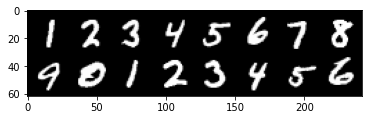

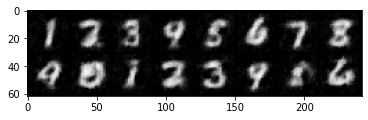

epoch : 5/10, Train loss = 0.036772
epoch : 5/10, Test loss = 0.035225


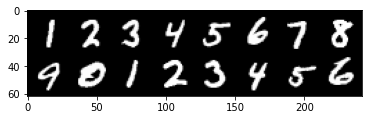

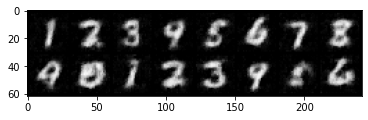

epoch : 6/10, Train loss = 0.035030
epoch : 6/10, Test loss = 0.033816


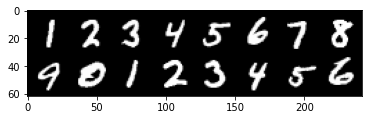

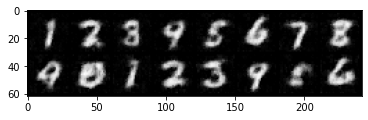

epoch : 7/10, Train loss = 0.033760
epoch : 7/10, Test loss = 0.032785


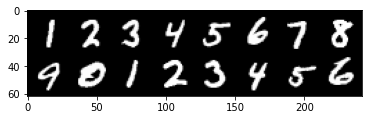

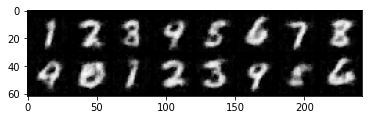

epoch : 8/10, Train loss = 0.032850
epoch : 8/10, Test loss = 0.031799


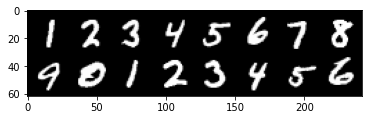

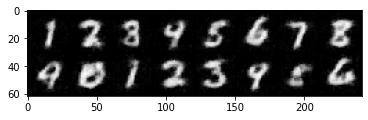

epoch : 9/10, Train loss = 0.032183
epoch : 9/10, Test loss = 0.031209


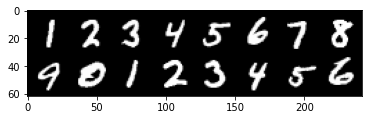

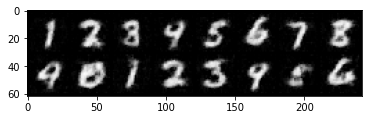

epoch : 10/10, Train loss = 0.031724
epoch : 10/10, Test loss = 0.030848


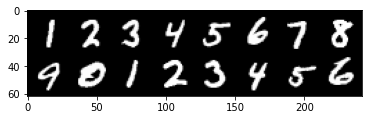

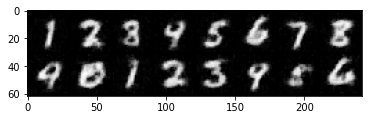

In [11]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion) 

# Variational Autoencoders (VAEs)

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


In [13]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = nn.MSELoss(reduction='sum')

    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return mse(recon_x, x) + KLD

In [14]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

# Exercise 2

Modify the training and test functions and train the Variational Autoencoder


In [15]:
def train_vae(model, loader, optimizer,  reshape=False):
    loss = 0
    for batch_features, _ in loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)

        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        decode, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = loss_function(decode, batch_features, mu, logvar)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test_vae(model, loader,  reshape=False):
    loss = 0
    for batch_features, _ in loader:
        
        batch_features = batch_features.to(device)
        
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            decode, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = loss_function(decode, batch_features, mu, logvar)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(test_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28), nrows=2))
    show_image(make_grid(decode.detach().cpu().view(-1, 1, 28, 28), nrows=2))

epoch : 1/10, Train loss = 5815.378754
epoch : 1/10, Test loss = 1170.798823


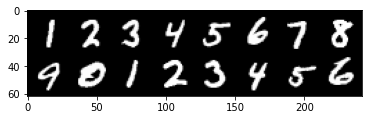

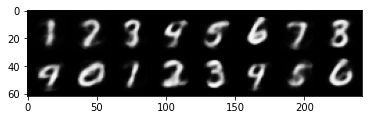

epoch : 2/10, Train loss = 4483.251162
epoch : 2/10, Test loss = 1069.616723


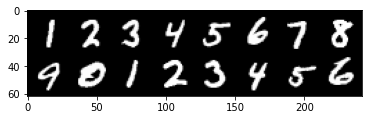

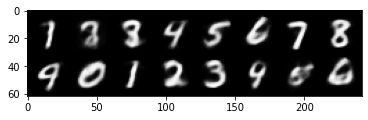

epoch : 3/10, Train loss = 4244.406701
epoch : 3/10, Test loss = 1034.057689


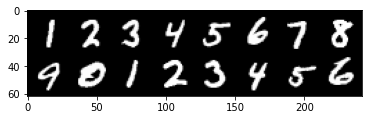

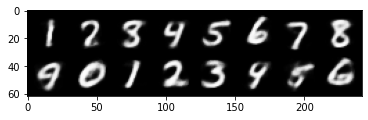

epoch : 4/10, Train loss = 4131.583170
epoch : 4/10, Test loss = 1013.426980


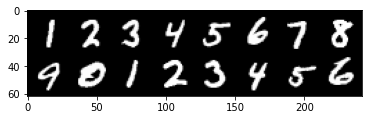

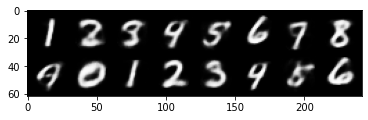

epoch : 5/10, Train loss = 4064.640249
epoch : 5/10, Test loss = 999.526193


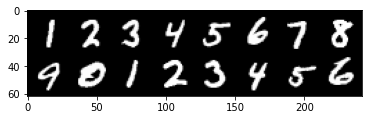

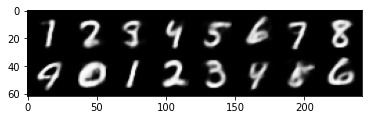

epoch : 6/10, Train loss = 4021.978958
epoch : 6/10, Test loss = 990.171436


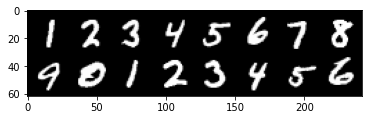

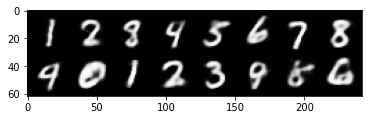

epoch : 7/10, Train loss = 3984.407980
epoch : 7/10, Test loss = 979.681321


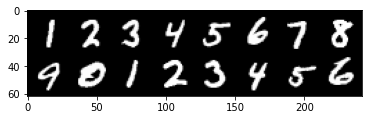

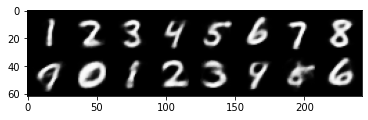

epoch : 8/10, Train loss = 3959.883320
epoch : 8/10, Test loss = 978.615007


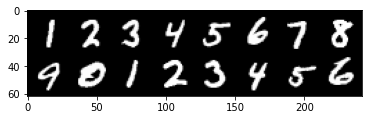

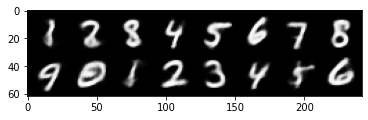

epoch : 9/10, Train loss = 3934.539917
epoch : 9/10, Test loss = 972.073496


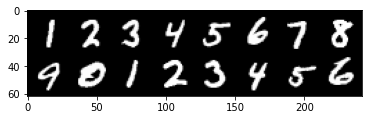

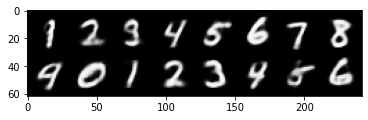

epoch : 10/10, Train loss = 3915.694117
epoch : 10/10, Test loss = 967.699279


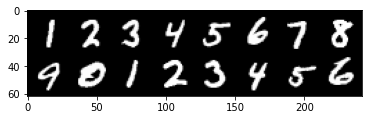

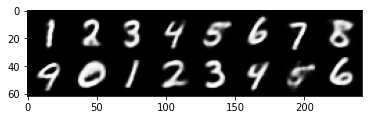

In [16]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, reshape = True)
    test_vae(model, test_loader, reshape = True) 

In [17]:
model.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.view(img1.size(0), -1).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        img2 = img2.view(img2.size(0), -1).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader):   
    # sort part of test set by digit
    digits = [[] for _ in range(10)]
    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000:
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10)

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[7][0], digits[1][0])
    
        inter_image = to_img(inter_image).view(1, 28, 28)
        
        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show() 

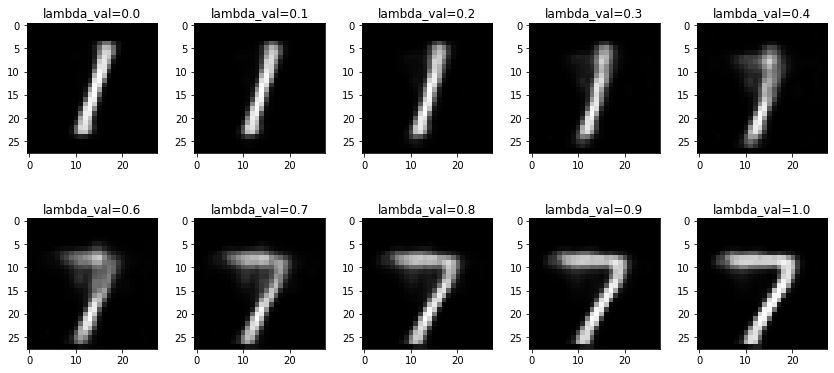

In [18]:
visualize_interpolation(model, test_loader)   

## Homework

A) Try both the simple encoder and the convolutional encoder with FashionMNIST dataset, comment what u observe for both results.

In [30]:
from torchvision import datasets, transforms

train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader_fashion = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=1)

**SIMPLE AUTOENCODER**

epoch : 1/10, Train loss = 0.043320
epoch : 1/10, Test loss = 0.007535


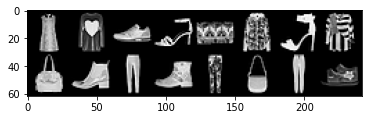

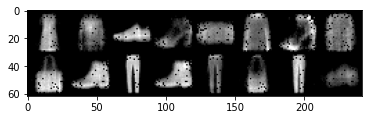

epoch : 2/10, Train loss = 0.027471
epoch : 2/10, Test loss = 0.006578


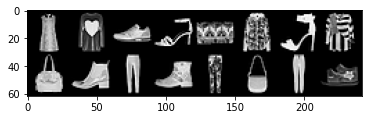

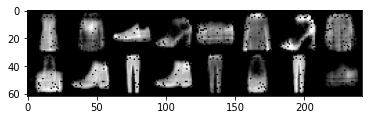

epoch : 3/10, Train loss = 0.025199
epoch : 3/10, Test loss = 0.006213


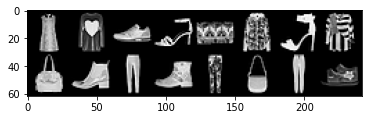

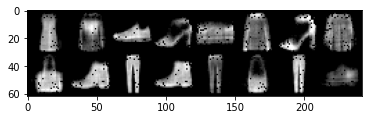

epoch : 4/10, Train loss = 0.024148
epoch : 4/10, Test loss = 0.006013


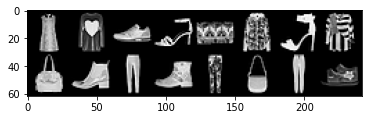

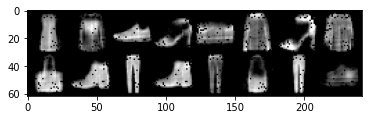

epoch : 5/10, Train loss = 0.023453
epoch : 5/10, Test loss = 0.005952


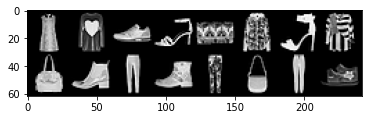

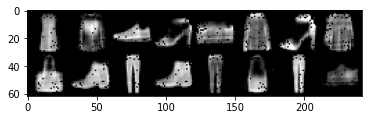

epoch : 6/10, Train loss = 0.022862
epoch : 6/10, Test loss = 0.005725


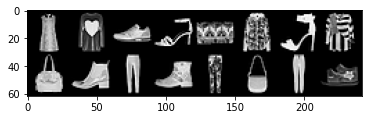

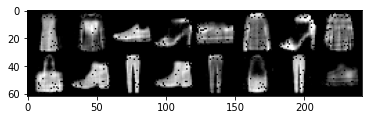

epoch : 7/10, Train loss = 0.022315
epoch : 7/10, Test loss = 0.005628


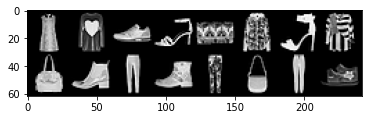

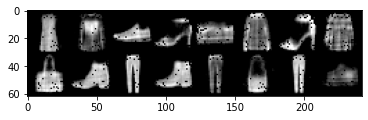

epoch : 8/10, Train loss = 0.021990
epoch : 8/10, Test loss = 0.005545


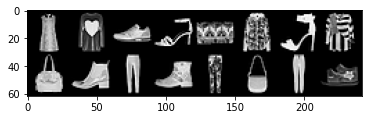

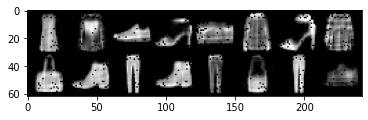

epoch : 9/10, Train loss = 0.021722
epoch : 9/10, Test loss = 0.005476


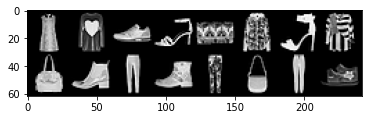

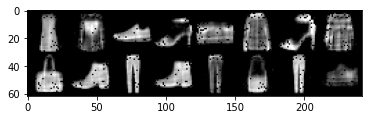

epoch : 10/10, Train loss = 0.021498
epoch : 10/10, Test loss = 0.005433


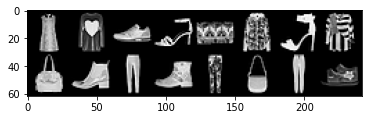

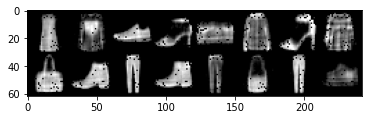

In [31]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_shape=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(model, train_loader_fashion, optimizer, criterion, reshape = True)
    test(model, val_loader, criterion, reshape = True) 

**CONVOLUTIONAL AUTOENCODER**

epoch : 1/10, Train loss = 0.064108
epoch : 1/10, Test loss = 0.009085


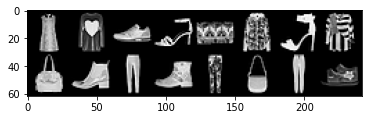

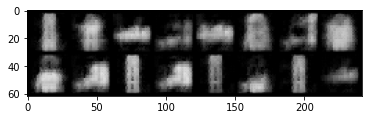

epoch : 2/10, Train loss = 0.031525
epoch : 2/10, Test loss = 0.007305


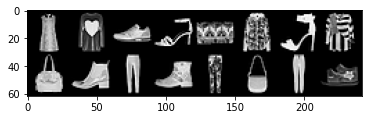

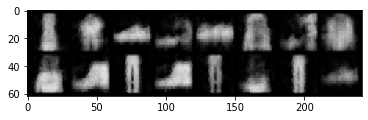

epoch : 3/10, Train loss = 0.027444
epoch : 3/10, Test loss = 0.006679


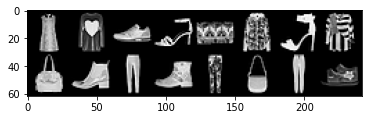

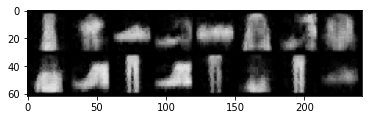

epoch : 4/10, Train loss = 0.025531
epoch : 4/10, Test loss = 0.006278


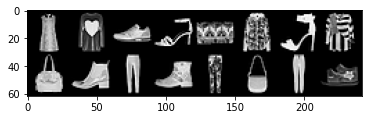

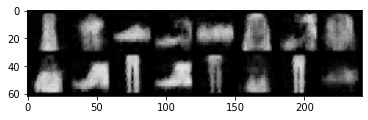

epoch : 5/10, Train loss = 0.024256
epoch : 5/10, Test loss = 0.006012


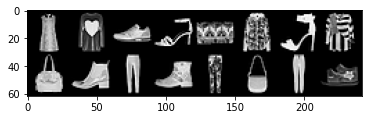

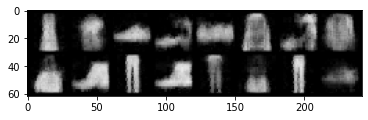

epoch : 6/10, Train loss = 0.023273
epoch : 6/10, Test loss = 0.005813


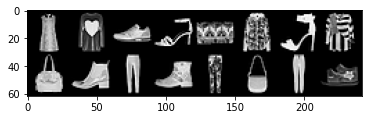

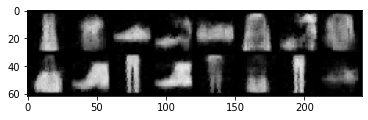

epoch : 7/10, Train loss = 0.022636
epoch : 7/10, Test loss = 0.005681


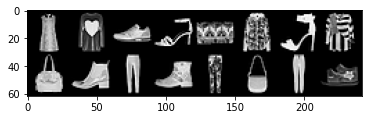

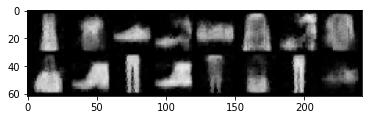

epoch : 8/10, Train loss = 0.022174
epoch : 8/10, Test loss = 0.005568


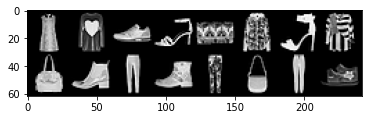

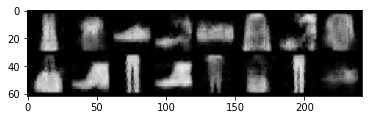

epoch : 9/10, Train loss = 0.021811
epoch : 9/10, Test loss = 0.005487


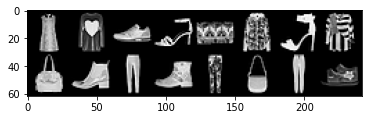

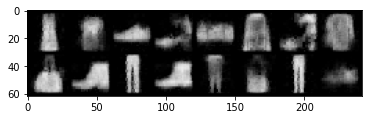

epoch : 10/10, Train loss = 0.021503
epoch : 10/10, Test loss = 0.005442


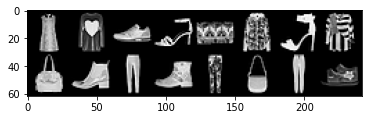

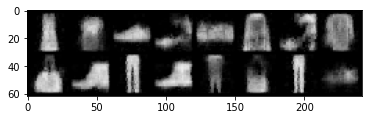

In [32]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(model, train_loader_fashion, optimizer, criterion)
    test(model, val_loader, criterion) 

Vemos que con el dataset de FashionMNIST, los AE y CAE se comportan de una forma bastante similar, con prácticamente la misma loss. Además, la calidad de deschifrado es también muy parecida en ambos casos.

B) Train the Variational autoencoder on the MNIST dataset. What is this loss funcion trying to optimize? Why is the reparametrization trick important.

epoch : 1/10, Train loss = 5814.060166
epoch : 1/10, Test loss = 1168.083622


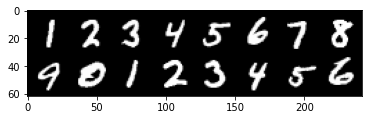

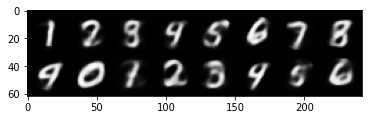

epoch : 2/10, Train loss = 4474.807205
epoch : 2/10, Test loss = 1069.926344


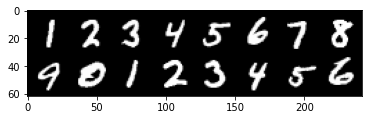

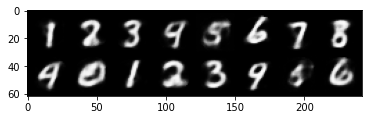

epoch : 3/10, Train loss = 4242.917835
epoch : 3/10, Test loss = 1034.264118


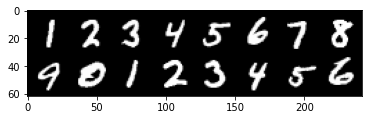

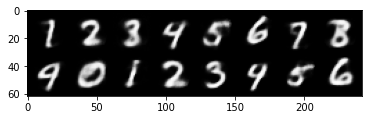

epoch : 4/10, Train loss = 4131.405361
epoch : 4/10, Test loss = 1015.539797


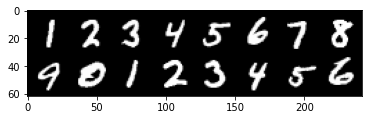

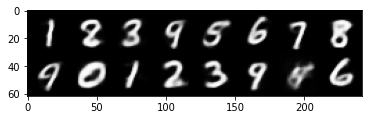

epoch : 5/10, Train loss = 4064.393659
epoch : 5/10, Test loss = 997.958750


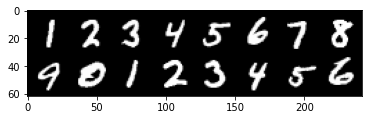

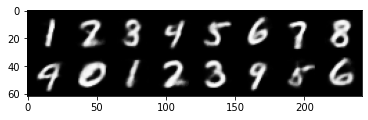

epoch : 6/10, Train loss = 4022.087458
epoch : 6/10, Test loss = 995.142204


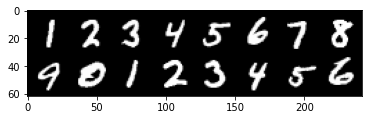

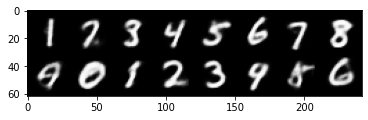

epoch : 7/10, Train loss = 3987.250086
epoch : 7/10, Test loss = 986.545178


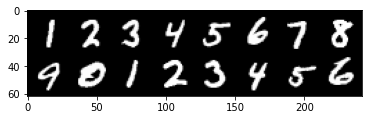

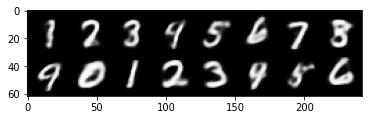

epoch : 8/10, Train loss = 3963.229307
epoch : 8/10, Test loss = 983.688389


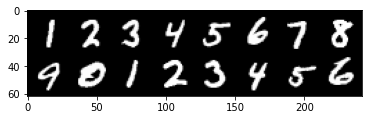

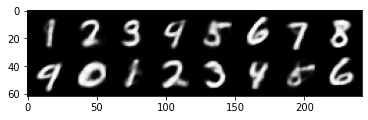

epoch : 9/10, Train loss = 3943.197330
epoch : 9/10, Test loss = 977.407963


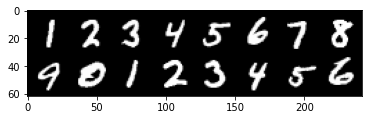

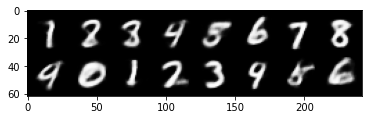

epoch : 10/10, Train loss = 3926.548128
epoch : 10/10, Test loss = 971.871952


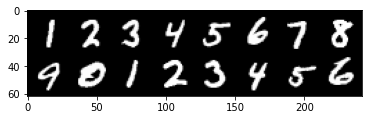

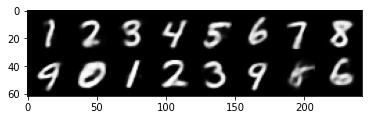

In [33]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, reshape = True)
    test_vae(model, test_loader, reshape = True) 

La loss function está intentando optimizar una reconstruction loss.

La reparametrization trick es importante porque nos permite entrenar el Variational AutoEncoder end-to-end.

C) Use the already trained VAE model to generate new digits. To do this think about what the decoder does and about the answer to question B).

source = https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=efM-mgK2PrTq

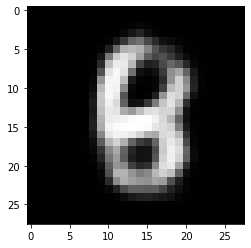

In [41]:
from random import randint

      
with torch.no_grad():
    # sample latent vectors from the normal distribution
    trans = torch.randn(20, device = device)

    # reconstruct images from the latent vectors
    inter_image = model.decode(trans)
    inter_image = inter_image.cpu()

    inter_image = to_img(inter_image).view(1, 28, 28)
        
    image = inter_image.numpy()
    fig = plt.plot(figsize = (15,15))
    plt.imshow(image[0,:,:], cmap='gray')
    plt.show()

D) Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and complete the cell below to visualize the entire 2D latent space.

source = https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=efM-mgK2PrTq

In [42]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1) 
        self.fc1 = nn.Linear(in_features=128*7*7, out_features= 2)
        self.fc2 = nn.Linear(in_features=128*7*7, out_features= 2)

        self.fc = nn.Linear(in_features= 2, out_features= 128*7*7)
        self.conv22 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv12 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)
            
    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc1(x), self.fc2(x)


    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return eps.mul(std).add_(mu)

    def decode(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7) 
        x = torch.relu(self.conv22(x))
        return torch.sigmoid(self.conv12(x))  

    def forward(self, x):
        mu, logvar = self.encode(x)
        latent = self.reparametrize(mu, logvar)
        x_recon = self.decode(latent)
        return x_recon, mu, logvar
    

epoch : 1/10, Train loss = 6049.505109
epoch : 1/10, Test loss = 1344.530304


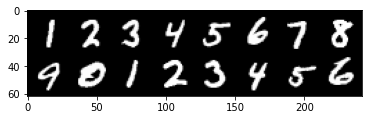

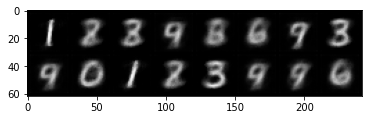

epoch : 2/10, Train loss = 5341.956084
epoch : 2/10, Test loss = 1312.390808


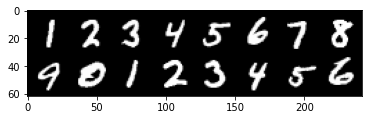

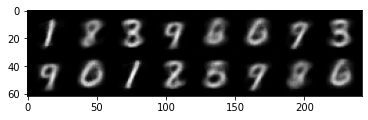

epoch : 3/10, Train loss = 5234.691846
epoch : 3/10, Test loss = 1295.990917


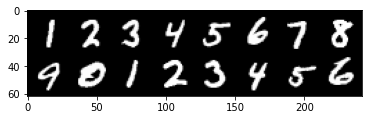

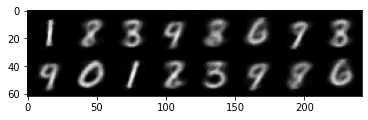

epoch : 4/10, Train loss = 5167.468642
epoch : 4/10, Test loss = 1281.133318


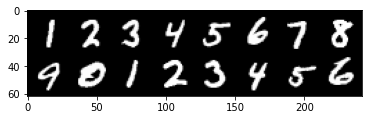

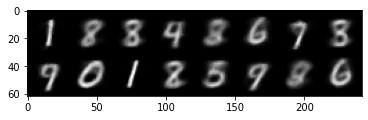

epoch : 5/10, Train loss = 5116.665374
epoch : 5/10, Test loss = 1271.169409


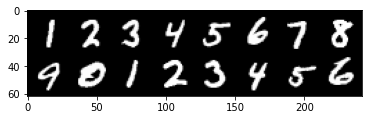

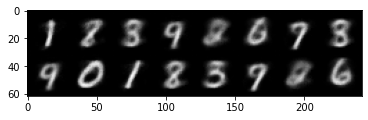

epoch : 6/10, Train loss = 5076.692848
epoch : 6/10, Test loss = 1257.277213


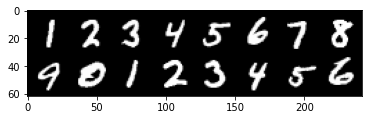

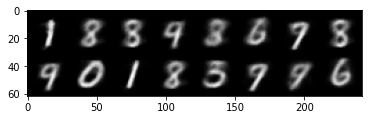

epoch : 7/10, Train loss = 5040.250123
epoch : 7/10, Test loss = 1253.369315


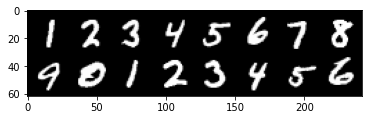

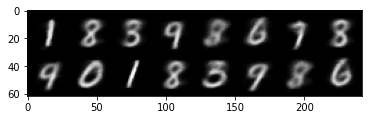

epoch : 8/10, Train loss = 5014.373790
epoch : 8/10, Test loss = 1249.421757


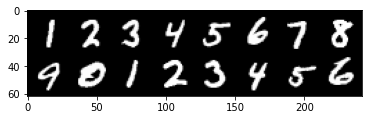

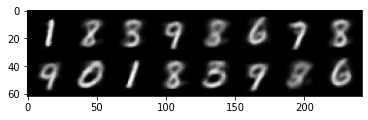

epoch : 9/10, Train loss = 4998.260006
epoch : 9/10, Test loss = 1247.132618


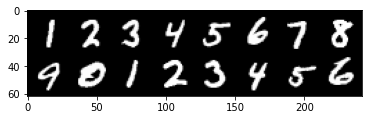

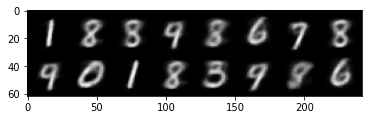

epoch : 10/10, Train loss = 4977.289445
epoch : 10/10, Test loss = 1242.227989


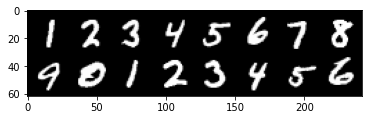

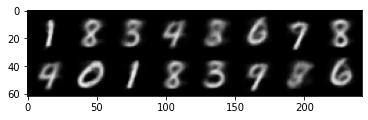

In [43]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, reshape = False)
    test_vae(model, test_loader, reshape=False)
    

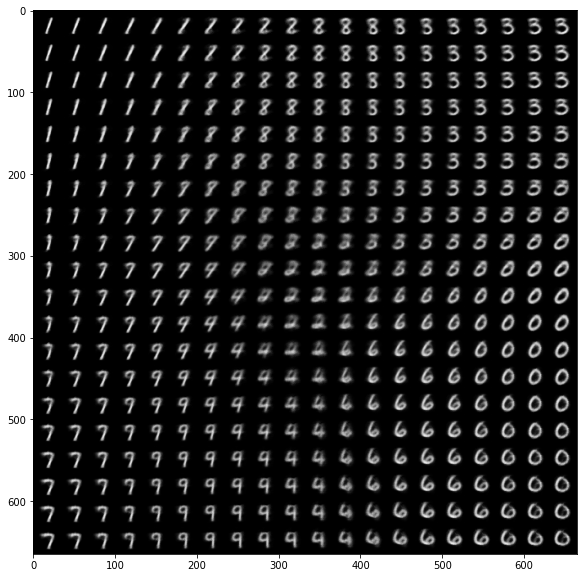

In [44]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
    latents = latents.to(device)
    images = model.decode(latents)
    images = images.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(images.view(-1, 1, 28, 28),20,5))
    plt.show()